# Load Data

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.cluster import KMeans
import shutil
import matplotlib.pyplot as plt

In [2]:
# Specify paths
train_dir = r'C:\Users\liuliuruxu\Desktop\Project\Dataset\train'
test_dir = r'C:\Users\liuliuruxu\Desktop\Project\Dataset\test'
valid_dir = r'C:\Users\liuliuruxu\Desktop\Project\Dataset\valid'
save_dir = r'C:\Users\liuliuruxu\Desktop\Project\ModelCode'

In [3]:
# Automatically skip truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
import tensorflow as tf

In [4]:
# Preprocess the dataset 
train_datagen = ImageDataGenerator( 
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='nearest')

# preprocess the valid dataset and test dataset
valid_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255)  

# load the train data  
train_generator = train_datagen.flow_from_directory(
    train_dir,                 
    target_size=(224, 224),    
    batch_size=16,             
    class_mode='binary',      
    shuffle=True,              
    color_mode='rgb',          
    seed=42                    
)     

# load the valid data 
valid_generator =valid_datagen.flow_from_directory(
    valid_dir, 
    target_size=(224, 224),    
    batch_size=16,          
    class_mode='binary',  
    shuffle=False,         
    color_mode='rgb',  
    seed=42
)  

# load the test data   
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  
    batch_size=16,
    class_mode='binary', 
    shuffle=False,   
    color_mode='rgb',
    seed=42
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# My Model

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling2D, GlobalAveragePooling2D,Dropout, MaxPooling2D, GlobalMaxPooling2D, Input, Dense, Conv2D, Multiply, Add, Activation, Concatenate, BatchNormalization

In [6]:
# CBAM
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_dense = Dense(channel // ratio, activation='relu')(avg_pool)
    avg_dense = Dense(channel, activation='sigmoid')(avg_dense)

    max_dense = Dense(channel // ratio, activation='relu')(max_pool)
    max_dense = Dense(channel, activation='sigmoid')(max_dense)

    attention = Add()([avg_dense, max_dense])
    attention = Activation('sigmoid')(attention)
    attention = Multiply()([input_feature, attention])
    return attention

def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    attention = Multiply()([input_feature, attention])
    return attention

def cbam_block(input_feature):
    x = channel_attention(input_feature)
    x = spatial_attention(x)
    return x

In [7]:
#Bottleneck Block
def bottleneck_block(x, filters, stride=1):  
    shortcut = x 

    # 1x1 Conv (Bottleneck - Compression)
    x = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3x3 Conv (Feature Extraction)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 1x1 Conv (Bottleneck - Expansion)
    x = Conv2D(filters * 4, (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x) 
    
    
    # CBAM Attention  
    x = cbam_block(x)

    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Residual Connection (Skip Connection)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [8]:
# CBAM-ResNet50
def my_resnet50(input_shape=(224, 224, 3)):      
    input_layer = Input(shape=input_shape)

    # Initial Conv Layer 
    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)  

    # Residual Blocks with CBAM   
    x = bottleneck_block(x, 64, stride=1)  # Stage 2  Conv2_x
    for _ in range(2):
        x = bottleneck_block(x, 64)

    x = bottleneck_block(x, 128, stride=2)  # Stage 3 Conv3_x
    for _ in range(3):
        x = bottleneck_block(x, 128)

    x = bottleneck_block(x, 256, stride=2)  # Stage 4 Conv4_x
    for _ in range(5):
        x = bottleneck_block(x, 256)

    x = bottleneck_block(x, 512, stride=2)  # Stage 5 Conv5_x
    for _ in range(2):
        x = bottleneck_block(x, 512)    

    # Global Average Pooling   
    x = GlobalAveragePooling2D()(x) 
    x = Dropout(0.5)(x)

    # Output Layers 
    fire_output = Dense(1, activation='sigmoid', name='fire_detection')(x) 

    model = Model(inputs=input_layer, outputs=fire_output)
    return model

In [9]:
model_myModel = my_resnet50()

In [10]:
model_myModel.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
model_myModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
# train my model
history_myModel = model_myModel.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
)

Epoch 1/10
1891/1891 [==============================] - 690s 346ms/step - loss: 0.2586 - accuracy: 0.8938 - val_loss: 0.1575 - val_accuracy: 0.9449
Epoch 2/10
1891/1891 [==============================] - 627s 331ms/step - loss: 0.1955 - accuracy: 0.9262 - val_loss: 0.1439 - val_accuracy: 0.9519
Epoch 3/10
1891/1891 [==============================] - 642s 339ms/step - loss: 0.1673 - accuracy: 0.9375 - val_loss: 0.2839 - val_accuracy: 0.8998
Epoch 4/10
1891/1891 [==============================] - 648s 342ms/step - loss: 0.1485 - accuracy: 0.9452 - val_loss: 0.0958 - val_accuracy: 0.9665
Epoch 5/10
1891/1891 [==============================] - 620s 328ms/step - loss: 0.1403 - accuracy: 0.9481 - val_loss: 0.1565 - val_accuracy: 0.9411
Epoch 6/10
1891/1891 [==============================] - 630s 333ms/step - loss: 0.1281 - accuracy: 0.9523 - val_loss: 0.0943 - val_accuracy: 0.9667
Epoch 7/10
1891/1891 [==============================] - 649s 343ms/step - loss: 0.1208 - accuracy: 0.9548 - val_

In [13]:
loss, accuracy = model_myModel.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

394/394 [==============================] - 30s 74ms/step - loss: 0.0540 - accuracy: 0.9805
Test Accuracy: 0.98


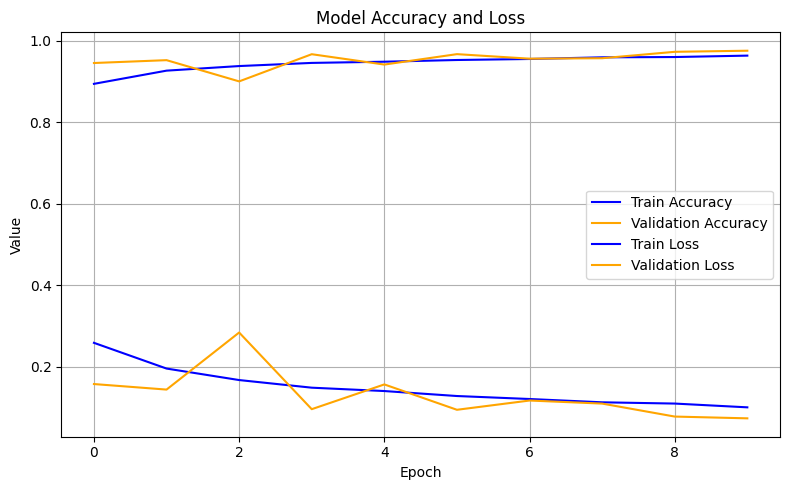

In [14]:
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(8, 5))

# Accuracy 
plt.plot(history_myModel.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_myModel.history['val_accuracy'], label='Validation Accuracy', color='orange')
# Loss 
plt.plot(history_myModel.history['loss'], label='Train Loss', color='blue')
plt.plot(history_myModel.history['val_loss'], label='Validation Loss', color='orange')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'myModel_accuracy_loss_combined.png'))
plt.show()

394/394 [==============================] - 24s 53ms/step
Confusion Matrix:
[[2762   58]
 [  65 3415]]


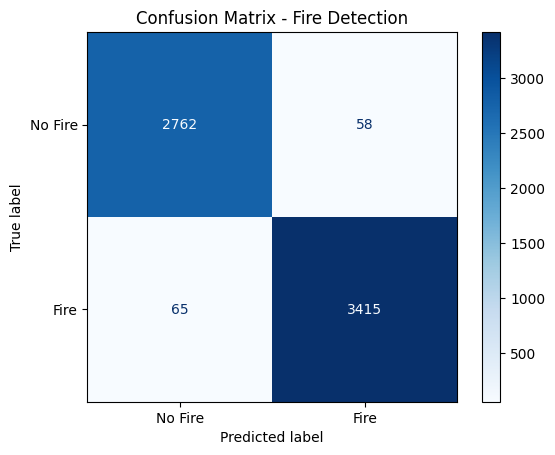


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2820
           1       0.98      0.98      0.98      3480

    accuracy                           0.98      6300
   macro avg       0.98      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

y_true = test_generator.classes
y_pred_prob =model_myModel.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fire Detection")
plt.savefig(os.path.join(save_dir, 'ConfusionMatrix_myModel.png'))
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, zero_division=1))

# inceptionV3

In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

In [17]:
#InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
inception_base.trainable = False 

# build model
model_incep = Sequential([
    inception_base,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

# compile model
model_incep.compile(optimizer=RMSprop(),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# train model
history_incep = model_incep.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)

Epoch 1/10
1891/1891 [==============================] - 579s 303ms/step - loss: 0.2416 - accuracy: 0.9071 - val_loss: 0.1858 - val_accuracy: 0.9332
Epoch 2/10
1891/1891 [==============================] - 581s 307ms/step - loss: 0.2233 - accuracy: 0.9175 - val_loss: 0.2480 - val_accuracy: 0.9127
Epoch 3/10
1891/1891 [==============================] - 579s 306ms/step - loss: 0.2138 - accuracy: 0.9208 - val_loss: 0.1719 - val_accuracy: 0.9392
Epoch 4/10
1891/1891 [==============================] - 575s 304ms/step - loss: 0.2137 - accuracy: 0.9206 - val_loss: 0.1618 - val_accuracy: 0.9433
Epoch 5/10
1891/1891 [==============================] - 576s 305ms/step - loss: 0.2126 - accuracy: 0.9197 - val_loss: 0.1636 - val_accuracy: 0.9410
Epoch 6/10
1891/1891 [==============================] - 576s 304ms/step - loss: 0.2169 - accuracy: 0.9205 - val_loss: 0.2464 - val_accuracy: 0.9103
Epoch 7/10
1891/1891 [==============================] - 576s 305ms/step - loss: 0.2120 - accuracy: 0.9224 - val_

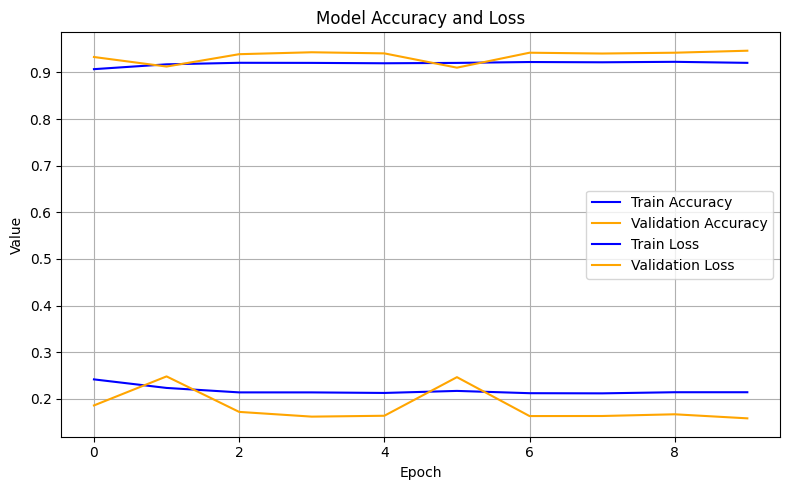

In [18]:
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(8, 5))

# Accuracy 
plt.plot(history_incep.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_incep.history['val_accuracy'], label='Validation Accuracy', color='orange')
# Loss 
plt.plot(history_incep.history['loss'], label='Train Loss', color='blue')
plt.plot(history_incep.history['val_loss'], label='Validation Loss', color='orange')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'incep_accuracy_loss.png'))
plt.show()

394/394 [==============================] - 24s 55ms/step
Confusion Matrix:
[[2653  167]
 [ 129 3351]]


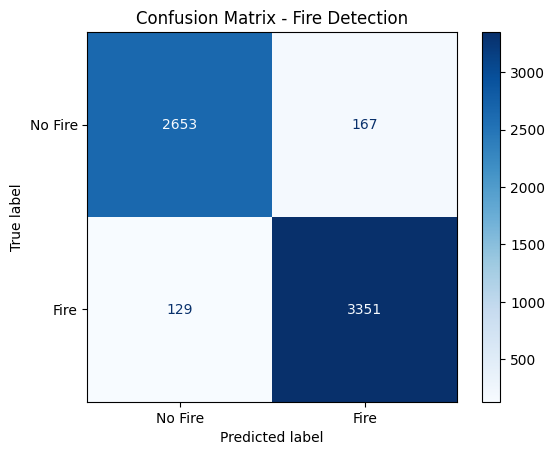


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2820
           1       0.95      0.96      0.96      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



In [19]:
y_true = test_generator.classes
y_pred_prob =model_incep.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fire Detection")
plt.savefig(os.path.join(save_dir, 'ConfusionMatrix_incep.png'))
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, zero_division=1))

# VGG16

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten

In [21]:
# build model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  

model_vgg16 = Sequential([
    vgg_base,
    Flatten(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# compile model
model_vgg16.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# train model
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)

Epoch 1/10
1891/1891 [==============================] - 577s 303ms/step - loss: 0.2929 - accuracy: 0.8900 - val_loss: 0.2216 - val_accuracy: 0.9262
Epoch 2/10
1891/1891 [==============================] - 571s 302ms/step - loss: 0.2981 - accuracy: 0.8968 - val_loss: 0.1817 - val_accuracy: 0.9405
Epoch 3/10
1891/1891 [==============================] - 580s 306ms/step - loss: 0.3007 - accuracy: 0.9010 - val_loss: 0.1760 - val_accuracy: 0.9475
Epoch 4/10
1891/1891 [==============================] - 581s 307ms/step - loss: 0.3059 - accuracy: 0.9026 - val_loss: 0.1903 - val_accuracy: 0.9448
Epoch 5/10
1891/1891 [==============================] - 583s 308ms/step - loss: 0.3158 - accuracy: 0.9009 - val_loss: 0.4432 - val_accuracy: 0.8851
Epoch 6/10
1891/1891 [==============================] - 572s 303ms/step - loss: 0.3224 - accuracy: 0.9050 - val_loss: 0.1941 - val_accuracy: 0.9448
Epoch 7/10
1891/1891 [==============================] - 523s 277ms/step - loss: 0.3235 - accuracy: 0.9035 - val_

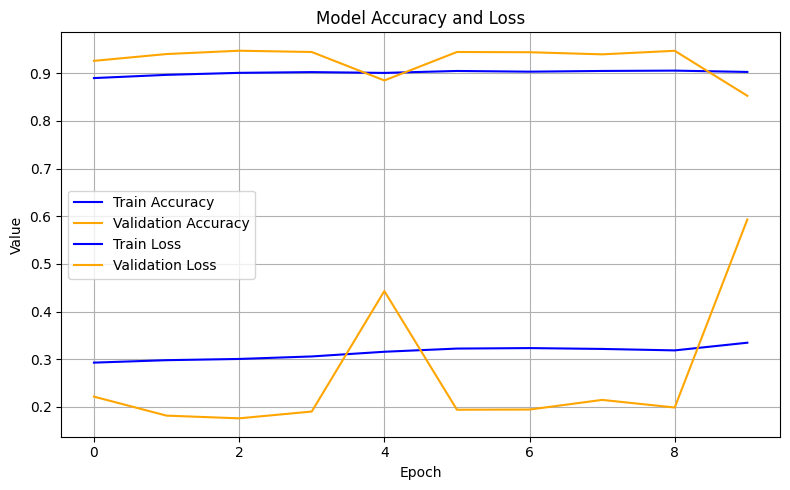

In [22]:
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(8, 5))

# Accuracy 
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy', color='orange')
# Loss 
plt.plot(history_vgg16.history['loss'], label='Train Loss', color='blue')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss', color='orange')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'incep_accuracy_loss.png'))
plt.show()

394/394 [==============================] - 28s 70ms/step
Confusion Matrix:
[[2800   20]
 [ 872 2608]]


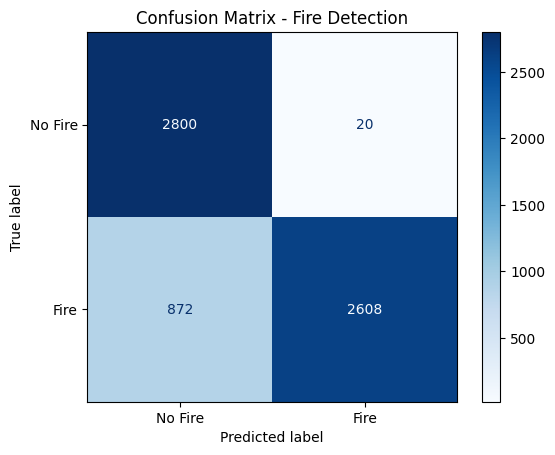


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2820
           1       0.99      0.75      0.85      3480

    accuracy                           0.86      6300
   macro avg       0.88      0.87      0.86      6300
weighted avg       0.89      0.86      0.86      6300



In [23]:
y_true = test_generator.classes
y_pred_prob =model_vgg16.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fire Detection")
plt.savefig(os.path.join(save_dir, 'ConfusionMatrix_vgg16.png'))
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, zero_division=1))

# Compare

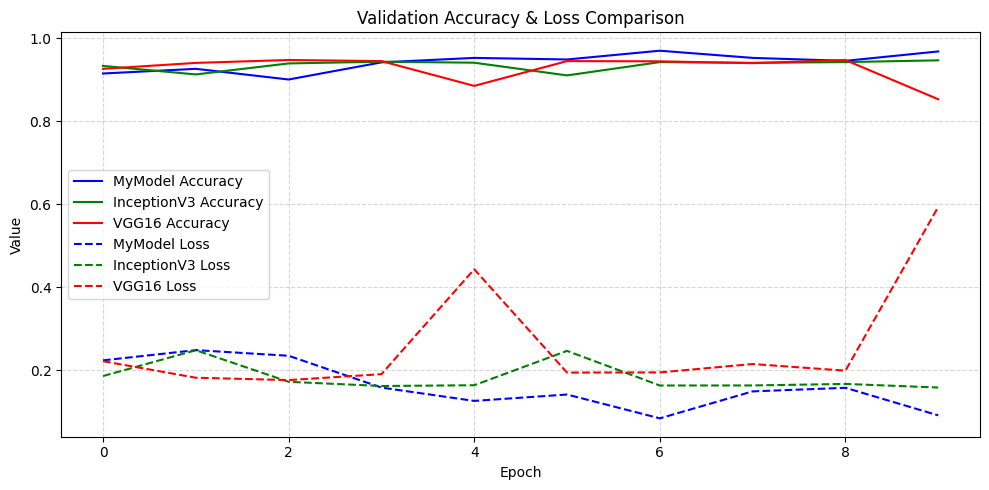

In [24]:
plt.figure(figsize=(10, 5))

# Accuracy
plt.plot(history_myModel.history['val_accuracy'], 'b-', label='MyModel Accuracy')
plt.plot(history_incep.history['val_accuracy'], 'g-', label='InceptionV3 Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], 'r-', label='VGG16 Accuracy')

# Loss
plt.plot(history_myModel.history['val_loss'], 'b--', label='MyModel Loss')
plt.plot(history_incep.history['val_loss'], 'g--', label='InceptionV3 Loss')
plt.plot(history_vgg16.history['val_loss'], 'r--', label='VGG16 Loss')

plt.title("Validation Accuracy & Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'compare_threeModel.png'))
plt.show()

# ablation study

#### Baseline-ResNet50

In [25]:
# no cabm
def bottleneck_block(x, filters, stride=1):
    shortcut = x

    # 1x1 Conv 
    x = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3x3 Conv
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 1x1 Conv
    x = Conv2D(filters * 4, (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def base_resnet50_no_cbam(input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Conv2_x
    x = bottleneck_block(x, 64, stride=1)
    for _ in range(2):
        x = bottleneck_block(x, 64)

    # Conv3_x
    x = bottleneck_block(x, 128, stride=2)
    for _ in range(3):
        x = bottleneck_block(x, 128)

    # Conv4_x
    x = bottleneck_block(x, 256, stride=2)
    for _ in range(5):
        x = bottleneck_block(x, 256)

    # Conv5_x
    x = bottleneck_block(x, 512, stride=2)
    for _ in range(2):
        x = bottleneck_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='fire_detection')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model    

model_base = base_resnet50_no_cbam()

model_base.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_163 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_147 (Batch  (None, 112, 112, 64  256        ['conv2d_163[0][0]']             
 Normalization)                 )                                                           

In [27]:
# train model
history_base = model_base.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
)

Epoch 1/10
1891/1891 [==============================] - 586s 310ms/step - loss: 0.1199 - accuracy: 0.9555 - val_loss: 0.1066 - val_accuracy: 0.9675
Epoch 2/10
1891/1891 [==============================] - 557s 294ms/step - loss: 0.1129 - accuracy: 0.9594 - val_loss: 0.1098 - val_accuracy: 0.9635
Epoch 3/10
1891/1891 [==============================] - 576s 305ms/step - loss: 0.1122 - accuracy: 0.9579 - val_loss: 0.0821 - val_accuracy: 0.9735
Epoch 4/10
1891/1891 [==============================] - 571s 302ms/step - loss: 0.1062 - accuracy: 0.9610 - val_loss: 0.1002 - val_accuracy: 0.9702
Epoch 5/10
1891/1891 [==============================] - 582s 308ms/step - loss: 0.1048 - accuracy: 0.9607 - val_loss: 0.3880 - val_accuracy: 0.8954
Epoch 6/10
1891/1891 [==============================] - 589s 311ms/step - loss: 0.1001 - accuracy: 0.9633 - val_loss: 0.0856 - val_accuracy: 0.9692
Epoch 7/10
1891/1891 [==============================] - 586s 309ms/step - loss: 0.0984 - accuracy: 0.9632 - val_

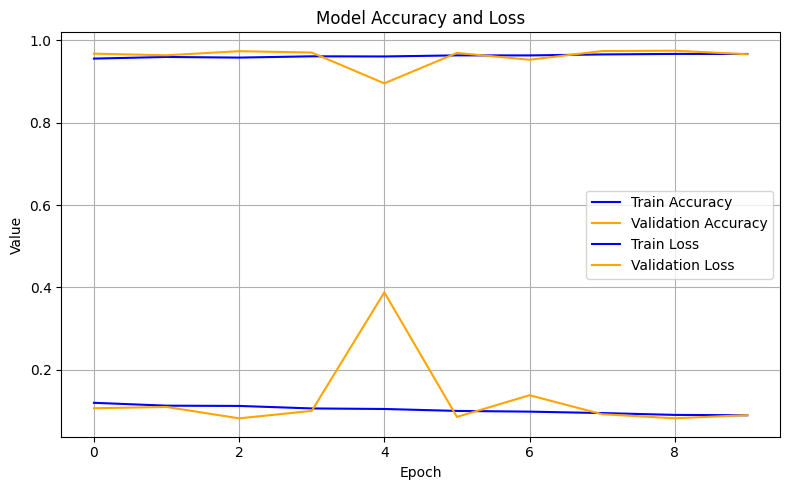

394/394 [==============================] - 25s 61ms/step
Confusion Matrix:
[[2771   49]
 [ 105 3375]]


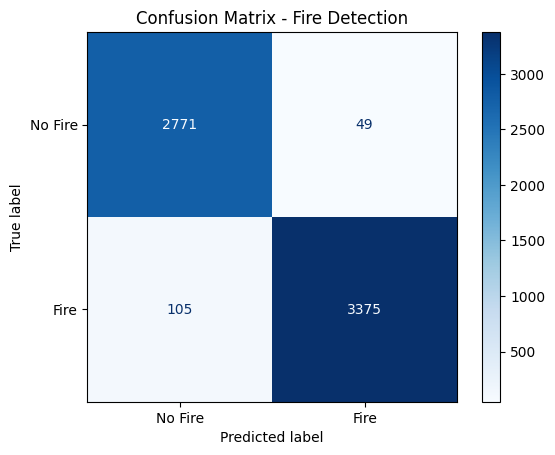


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2820
           1       0.99      0.97      0.98      3480

    accuracy                           0.98      6300
   macro avg       0.97      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300



In [28]:
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(8, 5))

# Accuracy 
plt.plot(history_base.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy', color='orange')
# Loss 
plt.plot(history_base.history['loss'], label='Train Loss', color='blue')
plt.plot(history_base.history['val_loss'], label='Validation Loss', color='orange')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'base_accuracy_loss_combined.png'))
plt.show()

y_true = test_generator.classes
y_pred_prob =model_base.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fire Detection")
plt.savefig(os.path.join(save_dir, 'ConfusionMatrix_base.png'))
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, zero_division=1))

# compare my model and Base-ResNet50

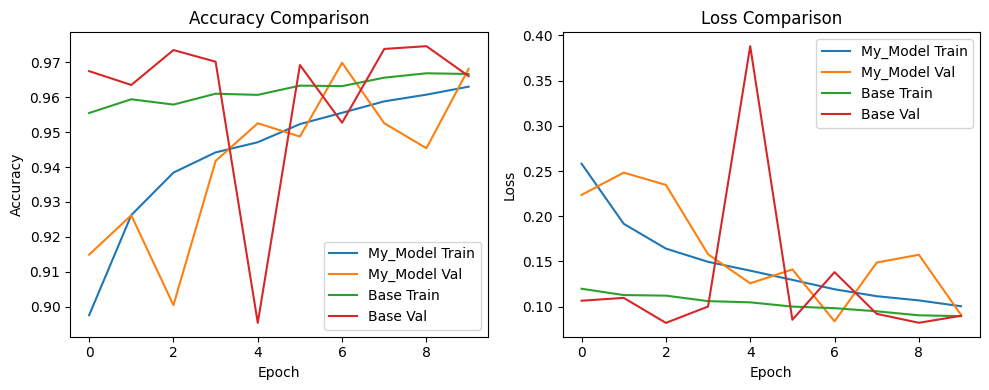

In [29]:
# Accuracy & Loss
def plot_compare(history_myModel, history_base, label1="My_Model", label2="Base"):
    plt.figure(figsize=(10, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_myModel.history['accuracy'], label=f'{label1} Train')
    plt.plot(history_myModel.history['val_accuracy'], label=f'{label1} Val')
    plt.plot(history_base.history['accuracy'], label=f'{label2} Train')
    plt.plot(history_base.history['val_accuracy'], label=f'{label2} Val')
    plt.title("Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_myModel.history['loss'], label=f'{label1} Train')
    plt.plot(history_myModel.history['val_loss'], label=f'{label1} Val')
    plt.plot(history_base.history['loss'], label=f'{label2} Train')
    plt.plot(history_base.history['val_loss'], label=f'{label2} Val')
    plt.title("Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'myModel_base_accuracy_loss_compare.png'))
    plt.show()
    
plot_compare(history_myModel, history_base)